# Practica 1 - Preprocesamiento de datos y evaluación de modelos de clasificación/regresión.

## Minería de Datos 2017/2018

* **Hernan Indibil de La Cruz Calvo**
* **Alejandro Martín Simón Sánchez**


### Preliminares

In [1]:
# Se cargan los paquetes que se suelen utilizar
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

# Misc
import base64

In [2]:
# Se configura matplotlib adecuadamente
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

In [3]:
# Se establece una semilla predeterminada para que los experimentos sean reproducibles
seed = 6470
np.random.seed(seed)

* **Lo siguiente es cargar los datos que se van a utilizar.**

    Se usa como label la variable categórica.

In [4]:
# Diccionario de nombre: fichero, con los datos de los dataframe a cargar
files = {
    'pima': '../data/pima.csv',
    'wisconsin': '../data/wisconsin.csv'
}

In [5]:
# Se cargan los dataframes
dfs = {name: pd.read_csv(file, dtype={ "label": 'category'}) for name, file in files.items()}

In [6]:
# Se comprueba que se han cargado bien los datos de Pima
dfs['pima'].head(5)

,preg,plas,pres,skin,insu,mass,pedi,age,label
0,14,175,62,30,0,33.6,0.212,38,tested_positive
1,4,146,78,0,0,38.5,0.520,67,tested_positive
2,15,136,70,32,110,37.1,0.153,43,tested_positive
3,3,107,62,13,48,22.9,0.678,23,tested_positive
4,3,169,74,19,125,29.9,0.268,31,tested_positive


In [7]:
# Se comprueba que se han cargado bien los datos de Wisconsin
dfs['wisconsin'].head(5)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
0,1,5,1,1,1,2,1.0,3,1,1,benign
1,2,5,4,4,5,7,10.0,3,2,1,benign
2,3,3,1,1,1,2,2.0,3,1,1,benign
3,4,6,8,8,1,3,4.0,3,7,1,benign
4,5,4,1,1,3,2,1.0,3,1,1,benign


** Se ha utilizado la función head para comprobar que los datos mostrados se corresponden con los 5 primeros casos. Así se puede ver a simple vista que se han cargado adecuadamente. **

**A continuación se utiliza la función sample para obtener muestras no sesgadas**

In [8]:
# Muestra aleatoria de Pima
np.random.seed(seed)
dfs['pima'].sample(8)

,preg,plas,pres,skin,insu,mass,pedi,age,label
276,0,126,84,29,215,30.7,0.520,24,tested_negative
179,2,105,80,45,191,33.7,0.711,29,tested_positive
755,1,103,80,11,82,19.4,0.491,22,tested_negative
762,6,92,92,0,0,19.9,0.188,28,tested_negative
419,2,112,66,22,0,25.0,0.307,24,tested_negative
34,0,84,64,22,66,35.8,0.545,21,tested_negative
722,1,88,78,29,76,32.0,0.365,29,tested_negative
99,3,193,70,31,0,34.9,0.241,25,tested_positive


In [9]:
# Muestra aleatoria de Wisconsin
np.random.seed(seed)
dfs['wisconsin'].sample(8)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
533,534,5,1,1,1,2,1.0,1,1,1,benign
42,43,1,1,1,1,2,1.0,2,1,2,benign
393,394,10,10,10,1,6,1.0,2,8,1,malignant
77,78,3,1,1,1,2,2.0,7,1,1,benign
552,553,5,1,1,1,2,1.0,1,1,1,benign
277,278,1,1,1,1,2,1.0,3,1,1,benign
73,74,3,1,1,1,2,3.0,3,1,1,benign
516,517,8,4,4,1,6,10.0,2,5,2,malignant


# 1. Dataframe Pima_diabetes
## 1.1 Análisis exploratorio mediante gráficas y estadísticos.

Para trabajar con un conjunto de datos es importante conocerlo previamente.

Por ello se procede con la elaboración de gráficas.


In [10]:
# Funcion que genera histogramas dado un dataframe
def gMultipleHistogram(targetdf):
    # Primero se elimina la variable clase
    target_noclass = targetdf.drop('label', 1)
    # Ahora se generan los histogramas
    g = sns.FacetGrid(pd.melt(target_noclass), col="variable", sharey=False, sharex=False, col_wrap=2)
    g.map(sns.distplot, "value");   

Se imprimen los histogramas correspondientes con Pima

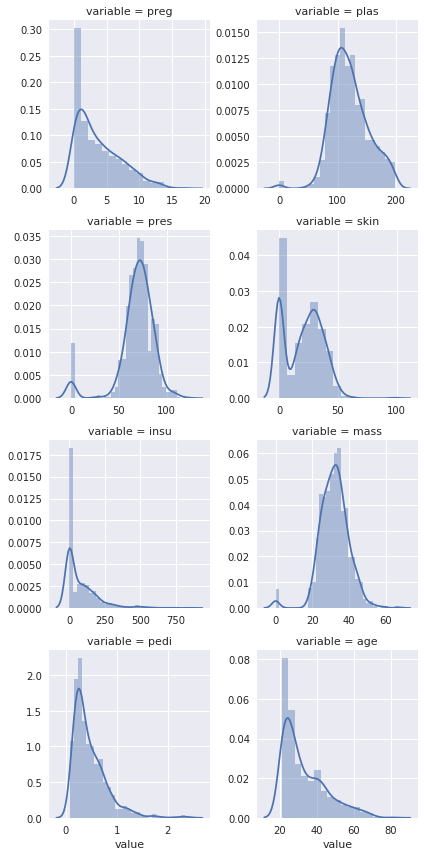

In [11]:
gMultipleHistogram(dfs['pima'])

Las variables se corresponden con:
1. preg = Numero de embarazos.
2. plas = Concentración de glucosa en plasma tras un test.
3. pres = Tension diastólica (mm Hg).
4. skin = Grosor del pliegue de la piel del triceps (mm).
5. insu = Insulina sérica en 2 horas (mu U/ml).
6. mass = Índice de masa corporal (kg/m^2).
7. pedi = Funcion de predisposicion genetica a la diabetes.
8. age = Edad (años).
9. label = Variable categórica (tested_positive o tested_negative).

· Los valores perdidos parecen estar codificados como 0 para las variables en las que un 0 no tiene sentido, como plas, pres, skin, insu y mass.

· Las variables preg y age siguen una distribución Poisson.

· El resto de las variables siguen una distribución normal.

_________-

    Se procede a mostrar la relación entre las variables y la variable clase.

In [12]:
def gSingleBoxplot(targetdf, att):
    sns.boxplot(x='label', y=att, data=targetdf)

def drawClassRelation(df, label='label'):
    glist = []
    for variable in df.columns.values:
        if (variable != label):
            gSingleBoxplot(df, variable)
            plt.show()
            
def gSingleBarplot(targetdf, att):
    sns.countplot(targetdf[att])

***Utilizamos diagramas de cajas y bigotes para representar los datos, ya que muestra de forma clara como se han distribuido los datos, así como los outliers.***


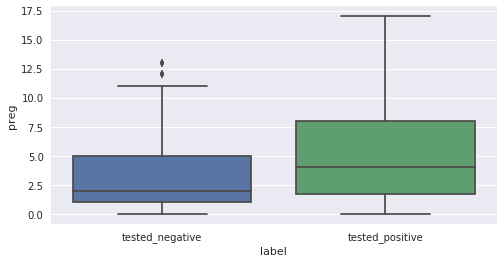

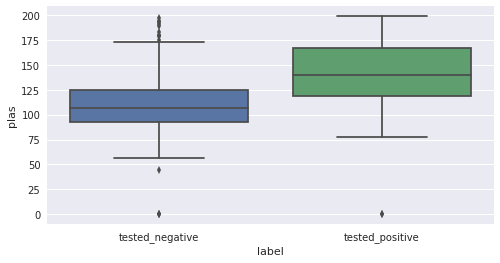

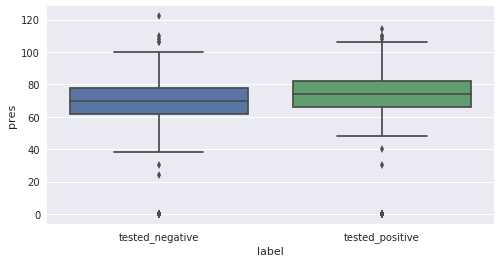

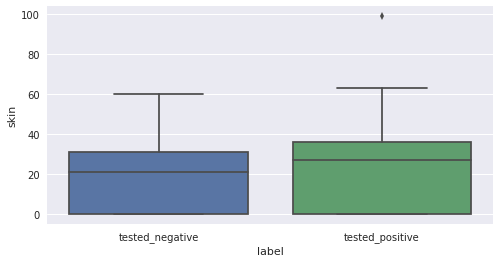

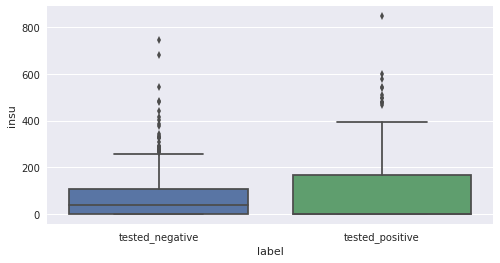

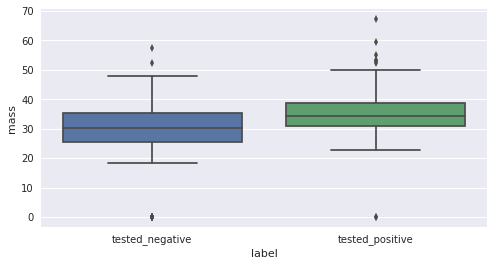

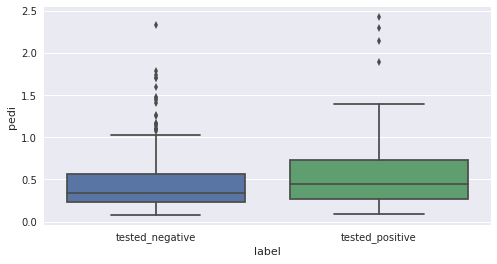

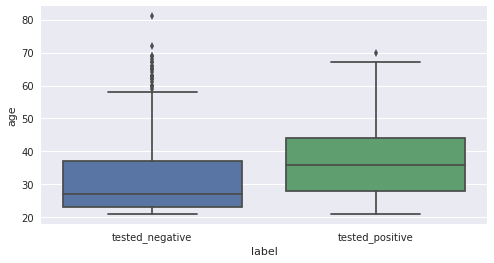

In [13]:
drawClassRelation(dfs['pima'])

En función de las variables se puede contemplar:

   · preg: existe cierta disposición a la diabetes cuando se pasa por un embarazo.

   · plas: una elevada concentración de glucosa en sangre muestra una probabilidad alta de que se pueda padecer diabetes.
    
   · pres: la presión sanguínea no tiene demasiada relevancia.
    
   · skin: el grosor de la piel no tiene relevancia.
   
   · insu: la mediana indica que niveles bajos de insulina suelen corresponderse con un resultado positivo de diabetes. Esto no se corresponde con el hecho de que la diabetes más común (tipo II) provoca valores elevados. Parece lógico que este efecto se produce debido a la sustitución de los valores perdidos por 0.
    
   · mass: es poco relevante, aunque se puede observar que en los casos clasificados como positivos hay cierta predisposición a tener un mayor índice de masa corporal.
    
   · pedi: por la posición de los cuartiles, así como el máximo, se puede contemplar que existe cierta predisposición genética a padecer diabétes.
    
   · age: se puede observar que es más habitual clasificar como negativo aquellos casos en los que la edad sea baja.

Las variables que más parece que puedan ayudar a clasificar son preg y plas, y dado que plas tiene valores perdidos codificados como cero, es probable que si se tratan de alguna forma ayude a clasificar más.

_______________________________________
**¿La variable clase está balanceada?**

Como se puede contemplar en el siguiente diagrama de barras hay más casos clasificados como tested_negative que tested_positive. Por ello no está balanceada.

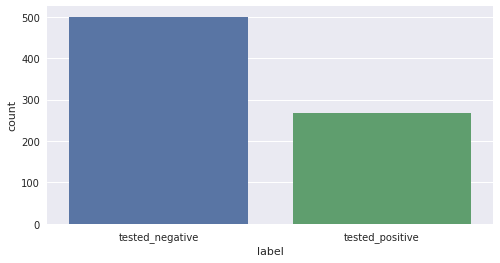

In [14]:
gSingleBarplot(dfs['pima'],"label")

_______
## 1.2. Aprendizaje y evaluación de un clasificador zeroR.
Lo primero que realizaremos será el tratamiento de datos para eliminar los valores perdidos.

In [15]:
dfPima = dfs['pima'].copy(deep=True) #guardamos el dataframe para poder compararlo sin preprocesamiento

# Reemplazo de los valores 0, que hemos identificado como perdidos, por NaN.
dfs['pima']['plas'] = dfs['pima']['plas'].replace(0, np.nan)
dfs['pima']['pres'] = dfs['pima']['pres'].replace(0, np.nan)
dfs['pima']['skin'] = dfs['pima']['skin'].replace(0, np.nan)
dfs['pima']['insu'] = dfs['pima']['insu'].replace(0, np.nan)
dfs['pima']['mass'] = dfs['pima']['mass'].replace(0, np.nan)

Para poder realizar un correcto proceso de aprendizaje y evaluación, es conveniente usar algún método como holdout balanceado. Es conveniente hacerlo balanceado sobre todo en casos en los que las variables no son balanceadas.

Para hacerlo, se define la siguiente función que nos devuelve a partir de un DataFrame, la base de datos de entrenamiento y la de test.

In [16]:
from sklearn.model_selection import train_test_split
def balHoldout(df, label, seed, tSize = 0.4):
    attributesdf = df.drop(label, 1)
    labeldf = df[label]
    train_atts, test_atts, train_label, test_label = train_test_split( 
        attributesdf, # Dataset con los atributos
        labeldf, # Vector/dataset con la clase
        test_size = tSize, # Proporcion de test
        random_state = seed, # Semilla
        stratify = labeldf) # Variable a estratificar
    return (train_atts.assign(label = train_label), test_atts.assign(label = test_label))

Ahora se definen las funciones para entrenar el clasificador zeroR y para evaluar un clasificador.

In [17]:
def trainZeroR(trainingData):
    # We first learn the parameters, aka, the most probable class
    # Tip! get the class variable mode and take the first value
    majorClass = trainingData.label.mode()[0]
    
    # Now we create and return the classifier function
    def classifier( data ):
        return data.assign( prediction = majorClass )
    
    return classifier

# The star notated argument are cale varargs, and can be passed to inner functions
def trainAndEvalClassifier(classifier, trainingDf, testDf, **kwargs):
    model = classifier(trainingDf, **kwargs)
    predictedDf = model(testDf)
    tab = pd.crosstab(predictedDf['label'], predictedDf['prediction'])
    comparison = predictedDf[predictedDf['label'] == predictedDf['prediction'] ]
    accuracy = len(comparison) / len(predictedDf)
    return (tab, accuracy)

Ya podemos proceder a realizar el proceso de Holdout balanceado y a sustituir los valores perdidos por la media.

In [18]:
(train_pima, test_pima) = balHoldout(dfs['pima'], 'label', seed)
meansValues = train_pima.mean()
train_pima = train_pima.fillna( meansValues )
test_pima = test_pima.fillna( meansValues )

A continuación, se procede con la evaluación de los datos de Pima. Almacenaremos la matriz de confusión para realizar la comparación con otros algoritmos posteriormente.

In [19]:
pimatabs = {}
(pimatabs['zeroR'], pimaaccuracy) = trainAndEvalClassifier(trainZeroR, train_pima, test_pima)
print ("Accuracy: ",pimaaccuracy)
pimatabs['zeroR']

Accuracy:  0.6525974025974026


prediction,tested_negative
label,
tested_negative,201
tested_positive,107


Dado que la semántica del problema parece indicar que lo más interesante es detectar los positivos y en este caso zeroR clasifica todo como negativo, es un mal algoritmo.

Se puede calcular un amplio abanico de ratios que nos permiten evaluar un clasificador con más objetividad. Definimos una función que a partir de una matriz de confusión calcula varios de estos valores.

Dado que tomar el accuracy por referencia no es un buen método para clasificar como bueno o malo el modelo se procede a realizar un análisis **ROC (Receiver Operating Characteristics)** a partir de la matriz de confusión.

In [20]:
# Función que calcula diversos datos a partir de la matriz de confusión
def calculateRates(cMatrix, posLabel, negLabel): # posLabel es la etiqueta considerada como positivos, al revés para negLabel
    stats = {}
    try:
        tp = cMatrix[posLabel][posLabel]
    except KeyError:
        tp = 0.0
    try:
        fp = cMatrix[posLabel][negLabel]
    except KeyError:
        fp = 0.0
    try:
        tn = cMatrix[negLabel][negLabel]
    except KeyError:
        tn = 0.0
    try:
        fn = cMatrix[negLabel][posLabel]
    except KeyError:
        fn = 0.0
    
    p = tp+fn
    n = tn+fp
    
    stats['p'] = p
    stats['n'] = n
    stats['tp'] = tp
    stats['tn'] = tn
    stats['fp'] = fp
    stats['fn'] = fn
    
    stats['tpr'] = tp/p
    stats['fpr'] = fp/n
    stats['tnr'] = tn/n
    stats['fnr'] = fn/p
    
    stats['accuracy'] = (tp+tn)/(p+n)
    try:
        stats['ppv'] = tp/(tp+fp)
    except ZeroDivisionError:
        stats['ppv'] = 0.0
    if (stats['ppv'] != 0 and stats['tpr'] != 0):
        stats['f1'] = (2*stats['tpr']*stats['ppv'])/(stats['ppv']+stats['tpr'])
    else:
        stats['f1'] = 0.0
        
    stats['mm'] = (stats['tpr']+stats['tnr'])/2
    
    return stats

El **recall/sensitivity/tpr** nos da una buena medida de lo bueno que es un algoritmo en el que lo importante es detectar los positivos. 

La **precisión/ppv** también es importante, ya que mide de los clasificados como positivos, cuáles lo son realmente. 

A partir de ambos valores se da el **F1 Score**, que trata de mostrar el balance entre ambas tasas.

In [21]:
rates = {}
rates['pima'] = {}
rates['pima']['zeroR'] = calculateRates(pimatabs['zeroR'], 'tested_positive', 'tested_negative')
print ('Recall: ', rates['pima']['zeroR']['tpr'])
print ('Precision: ', rates['pima']['zeroR']['ppv'])
print ('F1 Score: ', rates['pima']['zeroR']['f1'])

Recall:  0.0
Precision:  0.0
F1 Score:  0.0


Como los tres valores son 0, este clasificador es malo para este problema.

Los resultados de este algoritmo se analizarán posteriormente para poder compararlo con el resto.

## 1.3. Aprendizaje y evaluación de un clasificador oneR.
A continuación se define la función del clasificador oneR:

In [22]:
# Outer learning function, hyperparameter nbins=1 is equivalent to zeroR if all attributes are continuous
def trainOneR(trainingData, nbins = 1, debug = True):
    # Debug: 
    if debug:
        print("-----------------------------------")
        print("Training OneR")
        print("-----------------------------------")
        print("attribute\terror")
    # ------------------------------------

    # Loop maximization variables
    best_attribute = ''
    best_partitions = []
    best_classes = []
    best_error =  float("inf")

    # We discretize each attribute and compute its error
    for att in trainingData.columns.values: 
        # We must ignore the class variable
        if att == 'label': continue

        # First we generate the partitions
        (attribute, bins) = pd.cut(trainingData[att], bins=nbins, retbins=True)

        # The we must compute the error
        tab = pd.crosstab(attribute, trainingData['label'])
        error = sum( [ sum(f) - max(f) for f in tab.values ] )

        # We can show each variable individual error
        if debug:
            print(att, "\t", error)
        # ----------------------------------------
        
        # Lastly we compare if this attribute is better than the previous local optima
        if (error < best_error):
            # If that is the case we store it as the current local optima
            best_attribute  = att
            best_partitions = bins[1:-1]
            # We must store the majority class for each interval in order to assign it
            # during classification
            best_classes = [ tab.columns[f.argmax()] for f in tab.values ]
            best_error = error
    # Now we generate the classifier function regarding the previous parameters
    def classifier( testData ):
        # It simply assigns the majority class for each interval
        # For that we can use an auxiliar function to check which interval the current value
        # for the optimal attribute belongs to and assign the stored majority class
        def assignClass( attValue ):
            for i in range(nbins):
                if i != nbins - 1:
                    if attValue <= best_partitions[i]:
                        return best_classes[i]
                else:
                    if i - 1 >= 0:
                        if attValue > best_partitions[i - 1]:
                            return best_classes[i]

        # Now we apply the previous function to all the instances in the dataset
        # Remember that when using map in python3 we must cast the result as list
        prediction = list(map( assignClass, testData[best_attribute] ))

        return testData.assign( prediction = prediction )
    
    print("-----------------------------------")
    return classifier

A continuación se evalúan los datos de Pima:

In [23]:
(pimatabs['oneR'], pimaaccuracy) = trainAndEvalClassifier(trainOneR, train_pima, test_pima, nbins=len(dfs['pima'].label.unique()))
print ("Accuracy: ",pimaaccuracy)
pimatabs['oneR']

-----------------------------------
Training OneR
-----------------------------------
attribute	error
preg 	 148
plas 	 127
pres 	 161
skin 	 161
insu 	 161
mass 	 151
pedi 	 161
age 	 161
-----------------------------------
Accuracy:  0.7532467532467533


prediction,tested_negative,tested_positive
label,,
tested_negative,159,42
tested_positive,34,73


In [24]:
rates['pima']['oneR'] = calculateRates(pimatabs['oneR'], 'tested_positive', 'tested_negative')
print ('Recall: ', rates['pima']['oneR']['tpr'])
print ('Precision: ', rates['pima']['oneR']['ppv'])
print ('F1 Score: ', rates['pima']['oneR']['f1'])

Recall:  0.682242990654
Precision:  0.634782608696
F1 Score:  0.657657657658


## 1.4. Aprendizaje y evaluación de un árbol de decisión.

El aprendizaje y evaluación de árboles de decisión ya viene implementado en la librería Scikit-learn. Sin embargo, es necesario crear otra función diferente a trainAndEvalClassifier ya que ésta no funciona con los métodos que proporciona la librería.

In [25]:
from sklearn import tree
def trainAndEvalTree(trainDF, testDf, seed):
    # Init the model (set hyperparameters)
    model = tree.DecisionTreeClassifier(random_state=seed)
    features = trainDF.drop('label',1)
    labels = trainDF['label']
    
    # Use fit to learn from a configured model
    classifier = model.fit(features, labels)
    
    testFeatures = testDf.drop('label',1)
    prediction = classifier.predict(testFeatures)
    
    tab = pd.crosstab(testDf['label'], prediction)
    
    comparison = testDf[testDf['label'] == prediction]
    accuracy = len(comparison) / len(testDf)
    
    return (tab, accuracy)

Ahora procedemos a entrenar y probar un árbol con la base de datos:

In [26]:
(pimatabs['tree'], acc) = trainAndEvalTree(train_pima, test_pima, seed)
print ("Accuracy: ",acc)
pimatabs['tree']

Accuracy:  0.6623376623376623


col_0,tested_negative,tested_positive
label,,
tested_negative,150,51
tested_positive,53,54


In [27]:
rates['pima']['tree'] = calculateRates(pimatabs['tree'], 'tested_positive', 'tested_negative')
print ('Recall: ', rates['pima']['tree']['tpr'])
print ('Precision: ', rates['pima']['tree']['ppv'])
print ('F1 Score: ', rates['pima']['tree']['f1'])

Recall:  0.504672897196
Precision:  0.514285714286
F1 Score:  0.509433962264


## 1.5 Comparación de algoritmos

Lo siguiente que vamos a realizar es comparar los algoritmos, para ello hemos definido dos funciones: una para calcular el área bajo la curva y otra para dibujar el área ROC.

In [28]:
def calcAUC(fpr, tpr):
    auc = (fpr * tpr) / 2
    auc += (1 - fpr) * tpr
    auc += ((1 - fpr) * (1 - tpr)) / 2
    return auc

# Función que dibuja el area ROC
def drawRoc(fpr, tpr, lbl, fig):
    roc = fig.add_subplot(111)
    A = 0, fpr, 1
    B = 0, tpr, 1
    
    plt.plot(A, B)
    roc.annotate(lbl, xy=(fpr,tpr), textcoords='data')
    return calcAUC(fpr, tpr)

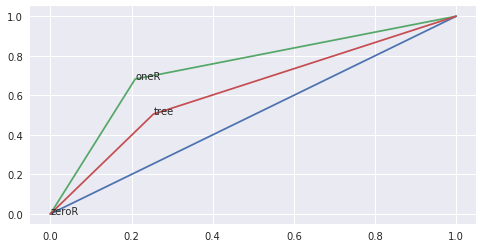

AUC ( zeroR ):  0.5
AUC ( oneR ):  0.736643883387
AUC ( tree ):  0.625470776956


In [29]:
fig = plt.figure()
AUC = {}
AUC['pima'] = {}
for k, v in rates['pima'].items():
    AUC['pima'][k] = drawRoc(v['fpr'], v['tpr'], k, fig)
plt.show()

for k, v in AUC['pima'].items():
    print ('AUC (', k, '): ', v)

Como podemos observar, el que peor clasifica es el zeroR, que tiene un área bajo la curva (AUC en adelante), de 0.5.
El que mejor clasifica es el oneR.

# 2. Dataframe Wisconsin
## 2.1 Análisis exploratorio mediante gráficas y estadísticos.

Se imprimen los histogramas correspondientes con Wisconsin

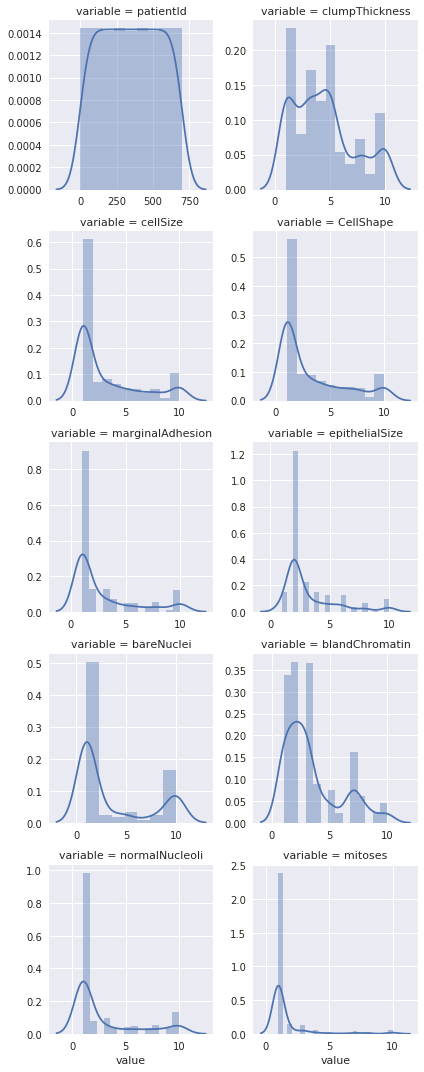

In [30]:
gMultipleHistogram(dfs['wisconsin'])

Las variables se corresponden con:
1. patientId = Número de identificación del paciente.
2. clumpThickness = Grosor de grupo.
3. cellSize = Tamaño de la célula.
4. CellShape = Forma de la célula.
5. marginalAdhesion = Adhesión marginal.
6. epithelialSize = Tamaño epitelial. 
7. bareNuclei = Núcleo sin citoplasma. !!!!!!!!!!!!!!!!!!!!!!!!!!!
8. blandChromatin = Cromatina débil.
9. normalNucleoli = Núcleo normal. !!!!!!!!!!!!!!!!!!!!!!!!!!
10. mitoses = Mitosis.
11. label = Variable categórica (malignant o benign).

        
· Los datos perdidos correspondiente a una variable de casos concretos son "NA".

· La variable patientId, por su propio significado no es relevante a la hora de clasificar.
 
· Todas las variables siguen una distribución bimodal similar y existe una correlación fuerte entre todas ellas, exceptuando la variable patientId que sigue una distribución uniforme continua.
 

***Utilizamos diagramas de cajas y bigotes para representar los datos, ya que muestra de forma clara como se han distribuido los datos, así como los outliers.***

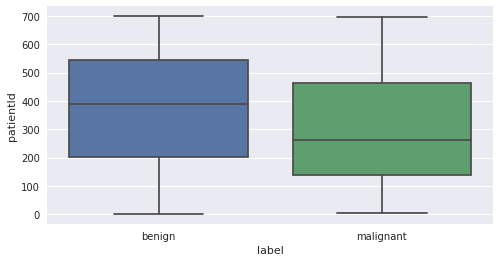

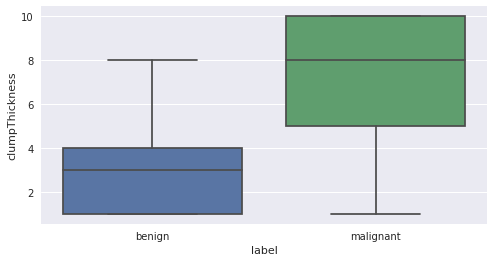

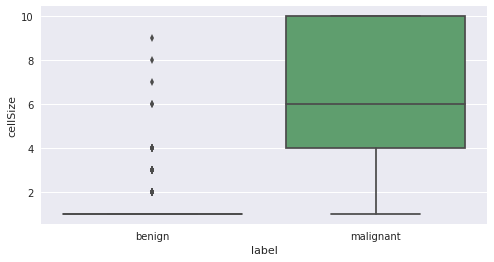

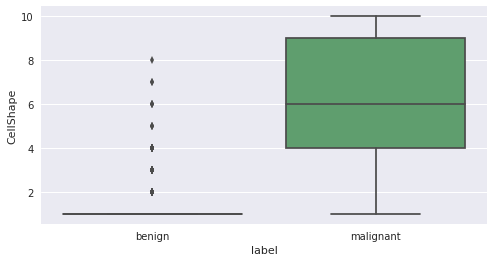

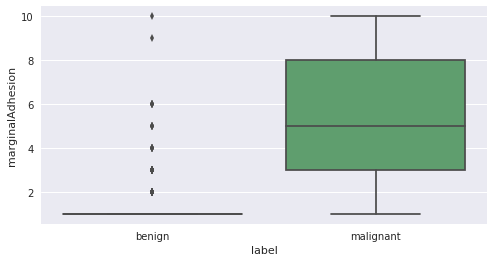

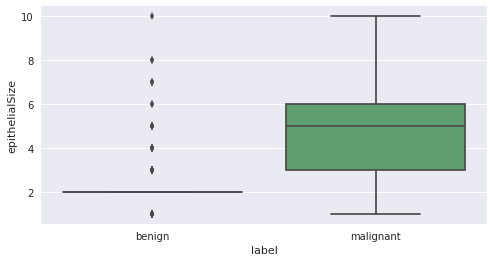

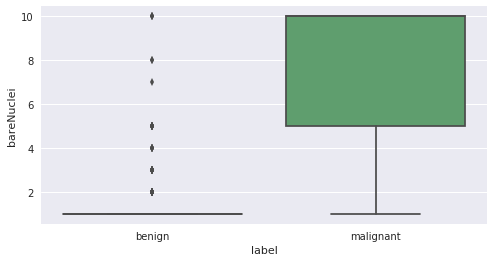

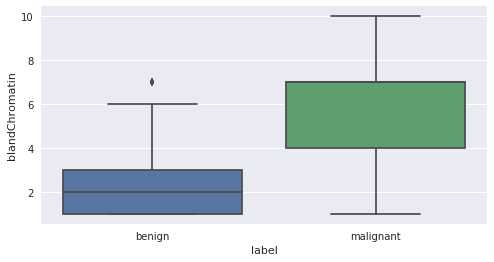

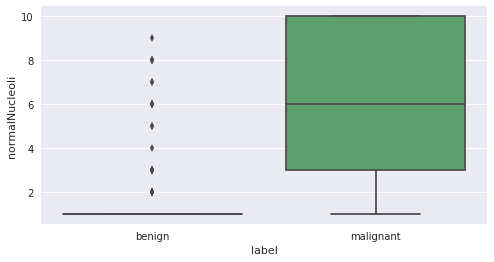

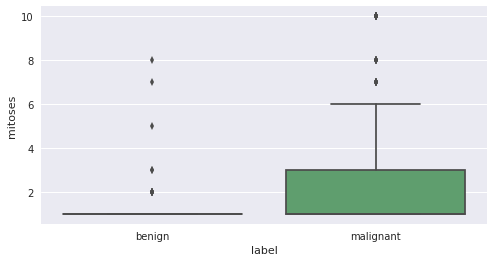

In [31]:
drawClassRelation(dfs['wisconsin'])

En función de las variables se puede contemplar:

    · patientId: como se comentó, no tiene sentido analizarla.

    · clumpThickness: valores bajos (benign), valores altos (malignant).

    · cellSize: valores bajos (benign), valores altos (malignant).

    · cellShape: valores bajos (benign), valores altos (malignant).

    · marginalAdhesion: valores bajos (benign), valores altos (malignant).

    · epithelialSize: valores cercanos a 2 (benign), valores alejados de 2 (malignant).

    · bareNuclei: valores bajos (benign), valores altos (malignant).

    · blandChromatin: valores bajos (benign), valores altos (malignant).

    · normalNucleoli: valores bajos (benign), valores altos (malignant).

    · mitoses: valores medio-alto (malignant).
    
 Como se puede observar la variable que mejor clasifica es normalNucleoli, junto con las relacionadas con el núcleo, el tamaño y la forma.

_________
**¿La variable clase es balanceada?**

Como se puede contemplar en el siguiente diagrama de barras hay considerablemente más clasificados como benign que malignant. Por ello no está balanceada.

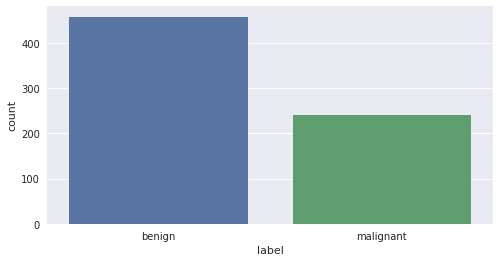

In [32]:
gSingleBarplot(dfs['wisconsin'],"label")

## 2.2. Aprendizaje y evaluación de un clasificador zeroR

Se procede a realizar el proceso de Holdout balanceado y se sustituyen los valores perdidos por la media.

In [33]:
(train_wisconsin, test_wisconsin) = balHoldout(dfs['wisconsin'], 'label', seed)
meansValues = train_wisconsin.mean()
train_wisconsin = train_wisconsin.fillna( meansValues )
test_wisconsin = test_wisconsin.fillna( meansValues )

A continuación, se procede con la evaluación de los datos de Wisconsin. Almacenaremos la matriz de confusión para realizar la comparación con otros algoritmos posteriormente.

In [34]:
wisconsintabs = {}
(wisconsintabs['zeroR'], wisconsinaccuracy) = trainAndEvalClassifier(trainZeroR, train_wisconsin, test_wisconsin)
print ("Accuracy: ",wisconsinaccuracy)
wisconsintabs['zeroR']

Accuracy:  0.6535714285714286


prediction,benign
label,
benign,183
malignant,97


Dado que la semántica del problema parece indicar que lo más interesante es detectar los casos en los que se clasifica como "malignant" y en este caso zeroR clasifica todo como "benign", es un mal algoritmo.

Se puede calcular un amplio abanico de ratios que nos permiten evaluar un clasificador con más objetividad. Definimos una función que a partir de una matriz de confusión calcula varios de estos valores.

Dado que tomar el accuracy por referencia no es un buen método para clasificar como bueno o malo el modelo se procede a realizar un análisis **ROC (Receiver Operating Characteristics)** a partir de la matriz de confusión.

El **recall/sensitivity/tpr** nos da una buena medida de lo bueno que es un algoritmo en el que lo importante es detectar los positivos. 

La **precisión/ppv** también es importante, ya que mide de los clasificados como positivos, cuáles lo son realmente. 

A partir de ambos valores se da el **F1 Score**, que trata de mostrar el balance entre ambas tasas.

In [35]:
rates = {}
rates['wisconsin'] = {}
rates['wisconsin']['zeroR'] = calculateRates(wisconsintabs['zeroR'], 'malignant', 'benign')
print ('Recall: ', rates['wisconsin']['zeroR']['tpr'])
print ('Precision: ', rates['wisconsin']['zeroR']['ppv'])
print ('F1 Score: ', rates['wisconsin']['zeroR']['f1'])

Recall:  0.0
Precision:  0.0
F1 Score:  0.0


## 2.3. Aprendizaje y evaluación de un clasificador oneR. 
A continuación se evalúan los datos de Wisconsin.

In [36]:
(wisconsintabs['oneR'], wisconsinaccuracy) = trainAndEvalClassifier(trainOneR, train_wisconsin, test_wisconsin, nbins=len(dfs['wisconsin'].label.unique()))
print ("Accuracy: ",wisconsinaccuracy)
wisconsintabs['oneR']

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 144
clumpThickness 	 52
cellSize 	 65
CellShape 	 67
marginalAdhesion 	 79
epithelialSize 	 91
bareNuclei 	 44
blandChromatin 	 64
normalNucleoli 	 76
mitoses 	 128
-----------------------------------
Accuracy:  0.8714285714285714


prediction,benign,malignant
label,,
benign,181,2
malignant,34,63


In [37]:
rates['wisconsin']['oneR'] = calculateRates(wisconsintabs['oneR'], 'malignant', 'benign')
print ('Recall: ', rates['wisconsin']['oneR']['tpr'])
print ('Precision: ', rates['wisconsin']['oneR']['ppv'])
print ('F1 Score: ', rates['wisconsin']['oneR']['f1'])

Recall:  0.649484536082
Precision:  0.969230769231
F1 Score:  0.777777777778


Ahora comprobamos si hay alguna mejora tratando los valores perdidos.

Se sustituyen los valores perdidos por la media:

## 2.4. Aprendizaje y evaluación de un árbol de decisión.

Ahora procedemos a entrenar y probar un árbol con la base de datos.

In [38]:
(wisconsintabs['tree'], acc) = trainAndEvalTree(train_wisconsin, test_wisconsin, seed)
print ("Accuracy: ",acc)
wisconsintabs['tree']

Accuracy:  0.9285714285714286


col_0,benign,malignant
label,,
benign,176,7
malignant,13,84


In [39]:
rates['wisconsin']['tree'] = calculateRates(wisconsintabs['tree'], 'malignant', 'benign')
print ('Recall: ', rates['wisconsin']['tree']['tpr'])
print ('Precision: ', rates['wisconsin']['tree']['ppv'])
print ('F1 Score: ', rates['wisconsin']['tree']['f1'])

Recall:  0.865979381443
Precision:  0.923076923077
F1 Score:  0.893617021277


## 2.5 Comparación de algoritmos

Lo siguiente que vamos a realizar es comparar los algoritmos.

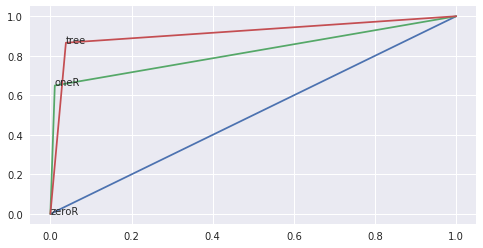

AUC ( zeroR ):  0.5
AUC ( oneR ):  0.819277787167
AUC ( tree ):  0.913864007662


In [40]:
fig = plt.figure()
AUC = {}
AUC['wisconsin'] = {}
for k, v in rates['wisconsin'].items():
    AUC['wisconsin'][k] = drawRoc(v['fpr'], v['tpr'], k, fig)
plt.show()

for k, v in AUC['wisconsin'].items():
    print ('AUC (', k, '): ', v)